In [1]:
from pytomoatt.model import ATTModel
import os
import numpy as np
import h5py
from scipy.ndimage import gaussian_filter

# Step 1. Generate the ATT model based on the crust1.0 model.

In [2]:
# generate the .h5 model for TomoATT based on the crust1.0 model. Nearest extrapolation is used.

param_file = "./3_input_params/input_params_real.yaml"
am_crust1p0 = ATTModel(param_file)
am_crust1p0.grid_data_crust1(type="vp")

2025-12-01 14:26:16,158 [Model] INFO: Grid data, please wait for a few minutes
2025-12-01 14:27:27,181 [Model] INFO: Done.


In [12]:
print(am_crust1p0.vel[::-1,0,0])
print(am_crust1p0.vel[::-1,0,1])
print(am_crust1p0.vel[::-1,1,0])

[5.9510807  5.9510807  5.9510807  5.9510807  5.9510807  5.9510807
 5.9510807  5.9510807  5.9510807  5.9510807  5.9510807  3.99078363
 5.40420176 7.61684204 7.45995806 7.95178573 7.9795454  7.97714442
 7.98277344 8.01269117 8.0828906  8.12125546 8.22017515 8.30589296
 8.30589296 8.30589296 8.30589296 8.30589296 8.30589296 8.30589296
 8.30589296 8.30589296 8.30589296 8.30589296 8.30589296 8.30589296
 8.30589296 8.30589296 8.30589296 8.30589296 8.30589296 8.30589296
 8.30589296 8.30589296 8.30589296 8.30589296 8.30589296 8.30589296
 8.30589296 8.30589296 8.30589296 8.30589296 8.30589296 8.30589296
 8.30589296 8.30589296 8.30589296 8.30589296 8.30589296 8.30589296
 8.30589296 8.30589296 8.30589296 8.30589296 8.30589296 8.30589296
 8.30589296 8.30589296 8.30589296 8.30589296 8.30589296 8.30589296
 8.30589296 8.30589296 8.30589296 8.30589296 8.30589296 8.30589296
 8.30589296 8.30589296 8.30589296 8.30589296 8.30589296 8.30589296
 8.30589296 8.30589296 8.30589296 8.30589296 8.30589296 8.30589

# Step 2. Generate the ATT model based on ak135 model.

In [3]:
# Step 2. Generate the ATT model based on ak135 model.

# ak135.h5 has a three-column dataset 'model'. First column: depth (in km), second column: Vp (in km/s), third column: Vs (in km/s).
# a text version of the ak135 model can be found in Kennett et al. (1995):
# Kennett, B. L., Engdahl, E. R., & Buland, R. (1995). Constraints on seismic velocities in the Earth from traveltimes. Geophysical Journal International, 122(1), 108-124.

# Load the 1D ak135 model from the .h5 file.
with h5py.File('ak135.h5', 'r') as f:
    points_ak135 = f['model'][:]

am_ak135 = ATTModel(param_file)

# interpolate the 1D ak135 velocity model to the depths of the ATT model.
am_depths = am_ak135.depths
vel_1d = np.interp(am_depths, points_ak135[:,0], points_ak135[:,1], left=points_ak135[0,1], right=points_ak135[-1,1])

# Set the 3D velocity model by tiling the 1D velocity model along lat and lon directions.
am_ak135.vel = np.tile(vel_1d[:, None, None], (1, am_ak135.n_rtp[1], am_ak135.n_rtp[2]))


# Step 3. Combine ak135 model with crust1.0 model

In [4]:
# 1. set two depths 
# if depth < depth_1,               vel = crust1p0 
# if depth_1 <= depth <= depth_2,   vel = linear_interp between crust1p0 and ak135 
# if depth > depth_2,               vel = ak135 

am_combined = ATTModel(param_file)

depth_1 = 35.0  
depth_2 = 70.0  

am_depths = am_ak135.depths
ratio = (am_depths - depth_1) / (depth_2 - depth_1)
ratio = np.clip(ratio, 0.0, 1.0)
ratio_3d = np.tile(ratio[:, None, None], (1, am_ak135.n_rtp[1], am_ak135.n_rtp[2]))

# linear interpolation
am_combined.vel = am_crust1p0.vel * (1 - ratio_3d) + am_ak135.vel * ratio_3d

# Step 4. post processing (OPTIONAL)

In [8]:
am_processed = ATTModel(param_file)
am_processed.vel = am_combined.vel.copy()

# 1. (OPTIONAL) monotonic increase check
# Ensure that the velocity model increases monotonically with depth.
print(am_processed.vel[::-1,0,0])
am_processed.vel[::-1,:,:] = np.maximum.accumulate(am_processed.vel[::-1,:,:], axis=0) 
print(am_processed.vel[::-1,0,0])

# 2. (OPTIONAL) Gaussian smoothing to the combined model to avoid sharp discontinuities.
sigma = [1, 1, 1]  # standard deviation for Gaussian kernel along each axis (ddep, dlat, dlon)
am_processed.vel = gaussian_filter(am_processed.vel, sigma=sigma, mode='nearest')


[5.9510807  5.9510807  5.9510807  5.9510807  5.9510807  5.9510807
 5.9510807  5.9510807  5.9510807  5.9510807  5.9510807  3.99078363
 5.40420176 7.61684204 7.45995806 7.95178573 7.9795454  7.97714442
 7.9910327  8.02082983 8.06526521 8.07616831 8.09357945 8.08100992
 8.04411765 8.04470588 8.04529412 8.04588235 8.04647059 8.04705882
 8.04764706 8.04823529 8.04882353 8.04941176 8.05       8.06388889
 8.07777778 8.09166667 8.10555556 8.11944444 8.13333333 8.14722222
 8.16111111 8.175      8.18888889 8.20277778 8.21666667 8.23055556
 8.24444444 8.25833333 8.27222222 8.28611111 8.3        8.31825
 8.3365     8.35475    8.373      8.39125    8.4095     8.42775
 8.446      8.46425    8.4825     8.50075    8.519      8.53725
 8.5555     8.57375    8.592      8.61025    8.6285     8.64675
 8.665      8.68325    8.7015     8.71975    8.738      8.75625
 8.7745     8.79275    8.811      8.82925    8.8475     8.86575
 8.884      8.90225    8.9205     8.93875    8.957      8.97525
 8.9935     9.011

In [9]:
# output as .h5 file
n_rtp = am_processed.n_rtp
fname = "constant_velocity_N%d_%d_%d_PyTomoATT.h5"%(n_rtp[0], n_rtp[1], n_rtp[2])
am_processed.write(fname)

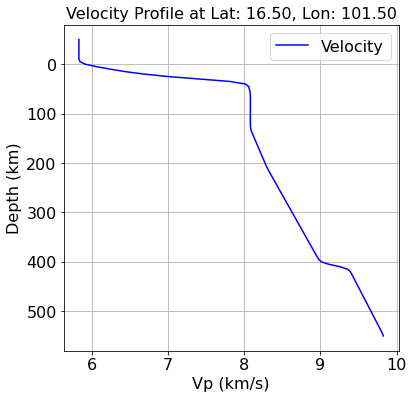

In [10]:
# visualization of the central lat-lon slice
import matplotlib.pyplot as plt
dep = am_processed.depths
vel = am_processed.vel[:, am_processed.n_rtp[1]//2, am_processed.n_rtp[2]//2]   
lat = am_processed.latitudes[am_processed.n_rtp[1]//2]
lon = am_processed.longitudes[am_processed.n_rtp[2]//2]
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)
ax.plot(vel, dep, label='Velocity', color='blue')
ax.invert_yaxis()
ax.set_xlabel('Vp (km/s)', fontsize=16)
ax.set_ylabel('Depth (km)', fontsize=16)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)

ax.set_title(f'Velocity Profile at Lat: {lat:.2f}, Lon: {lon:.2f}', fontsize=16)
ax.grid()
ax.legend(fontsize=16)
plt.show()

os.makedirs("figs", exist_ok=True)
fig.savefig("figs/velocity_profile_lat%.2f_lon%.2f.png"%(lat, lon), facecolor='white', edgecolor='white', bbox_inches='tight')